In [57]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import YOLOv1
from dataset import COCODataset, print_sample
from utils import (
    convert_cellboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from train import Compose
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from loss import YoloLoss
from collections import Counter

# Parameters

In [98]:
hp = {
    # model config
    'S': 4,
    'B': 2,
    'dropout': 0.5,
    'image_size': 256,
    # training config
    'lr': 2e-5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 8,
    'weight_decay': 0,
    'num_epochs': 10,
    'num_worker': 0,
    'Pin_memory': True,
    'load_model': True,
    'load_model_file': 'overfit.pth.tar',
    'max_training_samples': 100,
    # loss config
    'lambda_coord': 5,
    'lambda_noobj': 0.5,
    # validation config 
    'threshold':0.4,
    'iou_threshold':0.5,
    'validation_batches':10
}

# Util Functions

In [ ]:
def non_max_suppression(bboxes, threshold):
    assert type(bboxes) == list
    bboxes = [box for box in bboxes if box[0] > threshold]
    return bboxes

In [ ]:
def cellboxes_to_boxes(out, S=hp['S']):
    converted_pred = convert_cellboxes(out,S)
    converted_pred = converted_pred.reshape(out.shape[0], S * S, -1)
    return converted_pred.tolist()

In [95]:
def intersection_over_union(boxes_preds, boxes_labels):
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [100]:
def get_average_precision(
        loader,
        model,
        iou_threshold=0.5,
        threshold=0.4,
        split_size=hp['S'],
        validation_batches = 3,
        batch_size = 8):
    
    model.eval()
    epsilon = 1e-6
    
    #----------------------- Collect detections and ground truths ---------------------------#
    
    detections = []
    ground_truths = []
    
    for batch_idx, (x,y) in enumerate(loader):
        # shape y [batch_size,S,S,10]
        # shape x [batch_size,S*S*10]
        # Only compute for a fraction of images
        if batch_idx >= validation_batches:
            break
        x = x.to(hp['device'])
        
        with torch.no_grad():
            preds = model(x)
        preds.to('cpu')
            
        # iterate over batches
        for idx,pred in enumerate(preds):
            preds = pred.view([hp['S']*hp['S']*2,5])
            # reshape labels
            labels = torch.flatten(y[idx])
            labels = labels.view([hp['S']*hp['S']*2,5])
            # only get true labels
            labels = labels[labels[:,0]==1]
            # append image index in row
            if len(labels) != 0:
                index = torch.unsqueeze(torch.full([labels.shape[0]],(batch_idx*batch_size)+idx),1)
                labels = torch.cat((index,labels),1)
                for label in labels:
                    ground_truths.append(label.tolist())
            index = torch.unsqueeze(torch.full([hp['S']*hp['S']*2],(batch_idx*batch_size)+idx),1)
            preds = torch.cat((index,preds),1)
            for pred in preds:
                detections.append(pred.tolist())
            # pred and label shape = [n,6] [n,[image_index,prob,x1,x2,w,h]]
            
    #----------------------- Calculate the average precision ---------------------------#
        
    # find the amount of bboxes for each training example
    # Counter here finds how many ground truth bboxes we get
    # for each training example, so let's say img 0 has 3,
    # img 1 has 5 then we will obtain a dictionary with:
    # amount_bboxes = {0:3, 1:5}
    amount_bboxes = Counter([gt[0] for gt in ground_truths])
    # We then go through each key, val in this dictionary
    # and convert to the following (w.r.t same example):
    # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
    for key, val in amount_bboxes.items():
        amount_bboxes[key] = torch.zeros(val)
    # sort by box probabilities which is index 2
    detections.sort(key=lambda x: x[2], reverse=True)
    TP = torch.zeros((len(detections)))
    FP = torch.zeros((len(detections)))
    total_true_bboxes = len(ground_truths)
    # If none exists for this class then we can safely skip
    if total_true_bboxes == 0:
        return 0

    for detection_idx, detection in enumerate(detections):
        # Only take out the ground_truths that have the same
        # training idx as detection
        ground_truth_img = [
            bbox for bbox in ground_truths if bbox[0] == detection[0]
        ]
        best_gt_idx = 0
        best_iou = 0
        for idx, gt in enumerate(ground_truth_img):
            iou = intersection_over_union(
                torch.tensor(detection[2:]),
                torch.tensor(gt[2:]),
            )
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
        if best_iou > iou_threshold:
            # only detect ground truth detection once
            if amount_bboxes[detection[0]][best_gt_idx] == 0:
                # true positive and add this bounding box to seen
                TP[detection_idx] = 1
                amount_bboxes[detection[0]][best_gt_idx] = 1
            else:
                FP[detection_idx] = 1
        # if IOU is lower then the detection is a false positive
        else:
            FP[detection_idx] = 1
    TP_cumsum = torch.cumsum(TP, dim=0)
    FP_cumsum = torch.cumsum(FP, dim=0)
    recalls = TP_cumsum / (total_true_bboxes + epsilon)
    precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
    precisions = torch.cat((torch.tensor([1]), precisions))
    recalls = torch.cat((torch.tensor([0]), recalls))
    # torch.trapz for numerical integration
    return torch.trapz(precisions, recalls)

## Load Dataset

In [ ]:
transform = Compose([transforms.Resize((hp['image_size'], hp['image_size'])), transforms.ToTensor()])

### Load Training Data

In [ ]:
train_dataset_100 = COCODataset(transform=transform)
train_dataset_100.load_dataset()

In [ ]:
train_loader = DataLoader(  dataset=train_dataset_100, batch_size=hp["batch_size"], num_workers=hp["num_worker"],
                            pin_memory=hp["Pin_memory"], shuffle=True, drop_last=False)
print(f"Train loader initialized with: batch_size={hp['batch_size']} on device: {hp['device']}")

#### Print Stats

Training samples: 100
tensor([[[1.0000, 0.7286, 0.8555, 1.4104, 1.7111, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

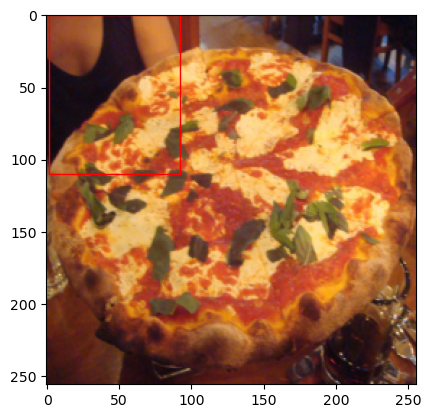

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.9820, 0.4099, 3.9159, 3.1261, 0.0000, 0.0000, 0.0000,
          0.0

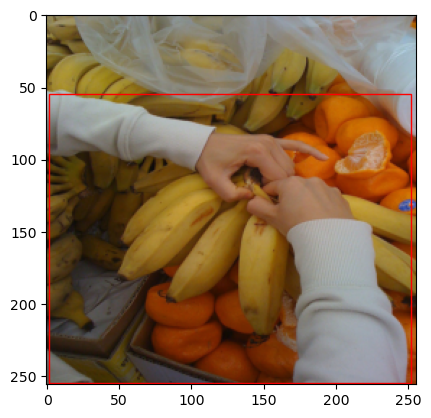

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[1.0000, 0.5287, 0.2090, 0.4742, 2.1487, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

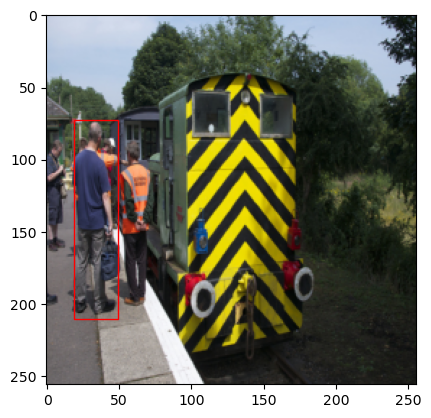

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Image shape: torch.Size([3, 256, 256])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.

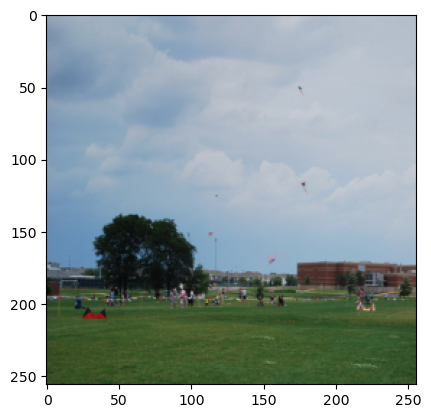

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.8838, 0.2909, 0.4212, 0.6312, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.6072, 0.3369, 0.4312, 1.5379, 0.0000, 0.0000, 0.0000,
          0.0

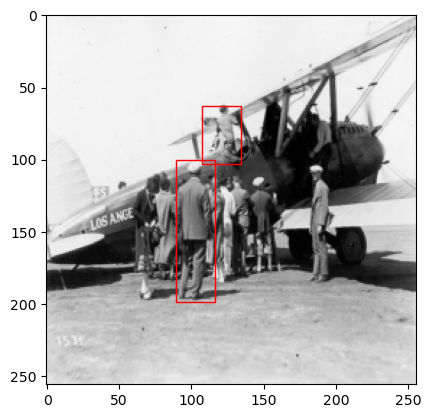

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Image shape: torch.Size([3, 256, 256])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.

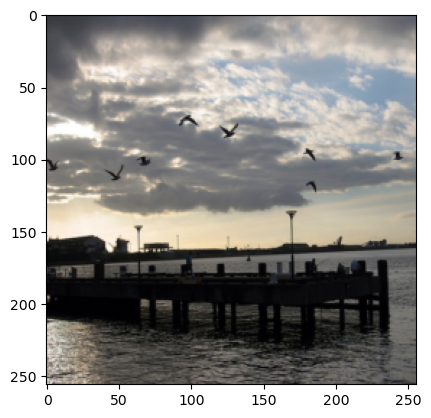

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Image shape: torch.Size([3, 256, 256])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.

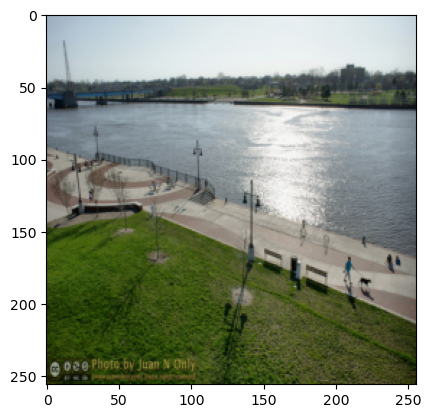

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[1.0000, 0.2209, 0.6049, 0.4283, 2.7561, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

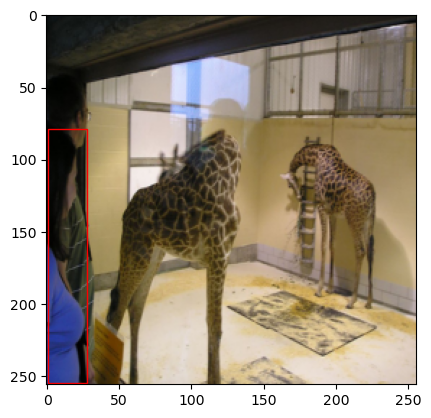

In [48]:
print(f"Training samples: {len(train_dataset_100)}")
# Display the first batch samples with true boxes
for x,y in train_loader:
    for idx in range(hp['batch_size']):
        print(y[idx])
        real_boxes = cellboxes_to_boxes(y.flatten(start_dim=1),hp['S'])
        print(f"Image shape: {x[idx].shape}")
        print(f"Box shape: {len(real_boxes[idx])}")
        print(f"The first Boxes are: {real_boxes[idx]}")
        plot_image(x[idx].permute(1,2,0).to("cpu"), real_boxes[idx])
    break

### Load Validation Data

In [ ]:
val_dataset_100 = COCODataset(transform=transform)
val_dataset_100.load_dataset("validation")

In [ ]:
val_loader = DataLoader(dataset=val_dataset_100, batch_size=hp["batch_size"], num_workers=hp["num_worker"],
                          pin_memory=hp["Pin_memory"], shuffle=True, drop_last=False)

#### Print Stats

In [ ]:
print(f"Validation samples: {len(val_dataset_100)}")

In [ ]:
for x,y in val_loader:
    for idx in range(hp['batch_size']):
        real_boxes = cellboxes_to_boxes(y.flatten(start_dim=1),hp['S'])
        print(f"Image shape: {x[idx].shape}")
        print(f"Box shape: {len(real_boxes[idx])}")
        print(f"The first Boxes are: {real_boxes[idx]}")
        plot_image(x[idx].permute(1,2,0).to("cpu"), real_boxes[idx])
    break

# Train Model

In [ ]:
model = YOLOv1().to(hp["device"])

In [ ]:
def test():
    x = torch.randn((8, 3, 256, 256))
    print(model(x).shape)
test()
print(f"Shape should be: [{hp['batch_size']}, {hp['S']*hp['S']*hp['B']*5}]")

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=hp["lr"], weight_decay=hp["weight_decay"])

In [ ]:
loss_fn = YoloLoss()

In [ ]:
def intermediate_print(out):
        for idx in range(8):
            bboxes = cellboxes_to_boxes(out, S=hp["S"])
            plot_image(x[idx].permute(1, 2, 0).to("cpu"), bboxes[idx])

In [ ]:
def train_fn(train_loader,val_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    ridx = torch.randint(0, len(train_loader), (1,)).item()
    #------------------- Training -------------------#
    mean_train_loss = []
    mean_train_box_loss = []
    mean_train_obj_loss = []
    mean_train_noobj_loss = []
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(hp["device"]), y.to(hp["device"])
        out = model(x)
        loss,box_loss,obj_loss,noobj_loss = loss_fn(out, y)
        mean_train_loss.append(loss.item())
        mean_train_box_loss.append(box_loss.item())
        mean_train_obj_loss.append(obj_loss.item())
        mean_train_noobj_loss.append(noobj_loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #if batch_idx == ridx:
            #intermediate_print(batch_idx,ridx,out)
        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean train loss was {sum(mean_train_loss)/len(mean_train_loss)}")
    print(f"Mean train Box loss was {sum(mean_train_box_loss)/len(mean_train_box_loss)}")
    print(f"Mean train Obj loss was {sum(mean_train_obj_loss)/len(mean_train_obj_loss)}")
    print(f"Mean train Noobj loss was {sum(mean_train_noobj_loss)/len(mean_train_noobj_loss)}")

    #------------------- Validation -------------------#
    model.eval()
    mean_val_loss = []
    mean_val_box_loss = []
    mean_val_obj_loss = []
    mean_val_noobj_loss = []
    with torch.no_grad():
        for (x, y) in val_loader:
            x, y = x.to(hp["device"]), y.to(hp["device"])
            out = model(x)
            loss,box_loss,obj_loss,noobj_loss = loss_fn(out, y)
            mean_val_loss.append(loss.item())
            mean_val_box_loss.append(box_loss.item())
            mean_val_obj_loss.append(obj_loss.item())
            mean_val_noobj_loss.append(noobj_loss.item())
    model.train()
    print(f"Mean validation loss was {sum(mean_val_loss)/len(mean_val_loss)}")
    print(f"Mean validation Box loss was {sum(mean_val_box_loss)/len(mean_val_box_loss)}")
    print(f"Mean validation Obj loss was {sum(mean_val_obj_loss)/len(mean_val_obj_loss)}")
    print(f"Mean validation Noobj loss was {sum(mean_val_noobj_loss)/len(mean_val_noobj_loss)}")
    return sum(mean_val_loss)/len(mean_val_loss)

In [96]:
best_loss = 1000
print(f"Train for {hp['num_epochs']} epochs.")
for epoch in range(hp["num_epochs"]):
    print(f"Epoch: {epoch}")
    #------------------- Training IOU -------------------#
    train_ap = get_average_precision(
            train_loader, model,iou_threshold=hp['iou_threshold'], threshold=0.4, split_size=hp["S"],validation_batches=hp['validation_batches'],batch_size=hp['batch_size']
    )
    print(f"Train Average Precision: {train_ap}")
    #------------------- Validation IOU -------------------#
    val_ap = get_average_precision(
            train_loader, model,iou_threshold=hp['iou_threshold'], threshold=0.4, split_size=hp["S"],validation_batches=hp['validation_batches'],batch_size=hp['batch_size']
    )
    print(f"Val Average Precision: {val_ap}")
    #------------------- Training -------------------#
    val_loss = train_fn(train_loader,val_loader, model, optimizer, loss_fn)
    #------------------- Checkpointing -------------------#
    if val_loss <= best_loss:
        best_loss = val_loss
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        print("=> Saving checkpoint")
        torch.save(checkpoint, hp["load_model_file"])

Train for 10 epochs.
Epoch: 0
Train mAP: 0.00045318162301555276
Val mAP: 0.0004853089922107756
=> Saving checkpoint


  8%|▊         | 1/13 [00:05<01:06,  5.51s/it, loss=51.4]


KeyboardInterrupt: 

# Validation

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
model = YOLOv1().to(hp["device"])
optimizer = optim.Adam(model.parameters(), lr=hp["lr"], weight_decay=hp["weight_decay"])
checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
}
load_checkpoint(torch.load(hp['load_model_file']), model, optimizer)

In [ ]:
def validation_print(out):
    bboxes = cellboxes_to_boxes(out, S=hp["S"])
    for idx in range(hp['batch_size']):
        best_boxes = non_max_suppression(bboxes[idx],hp['threshold'])
        plot_image(x[idx].permute(1, 2, 0).to("cpu"), best_boxes)

In [ ]:
model.eval()
with torch.no_grad():
    for (x, y) in val_loader:
        out = model(x)
        validation_print(out)
        break
model.train()

In [101]:
resulting_iou = get_average_precision(
            val_loader, model,iou_threshold=hp['iou_threshold'], threshold=0.4, split_size=hp["S"], validation_batches=hp['validation_batches'],batch_size=hp['batch_size']
)
print(f"Resulting Average Precision: {resulting_iou}")

Resulting IOU: 0.0013439361937344074
